## From https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

In [1]:
import imageio
    
imageio.plugins.ffmpeg.download()

In [2]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [4]:
print(digits['DESCR'])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

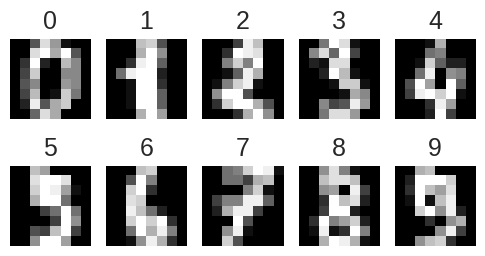

In [5]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
# plt.savefig('/tmp/images/digits-generated.png', dpi=150)

## Machine seems to be too small to run full set of data
### Set digits_data and digits_target to be a prefix of digits.data and data.target
### of size max_size
### n.b., digits_data seems to be in repeating sequence of digits from 0..9
###   so best to take a prefix rather than a random sample

In [6]:
max_size=min(800, digits.data.shape[0])
digits_data = digits.data[:max_size,:]
digits_target = digits.target[:max_size]

## Note that X, y are ordered so that groups of images corresponding to
## the same digit are adjacent (ordered from 0 to 9)
## When viewing X (are distances computed from X) we will see these groups

In [7]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits_data[digits_target==i]
               for i in range(10)])
y = np.hstack([digits_target[digits_target==i]
               for i in range(10)])

In [8]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [9]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [10]:
digits_proj.shape

(800, 2)

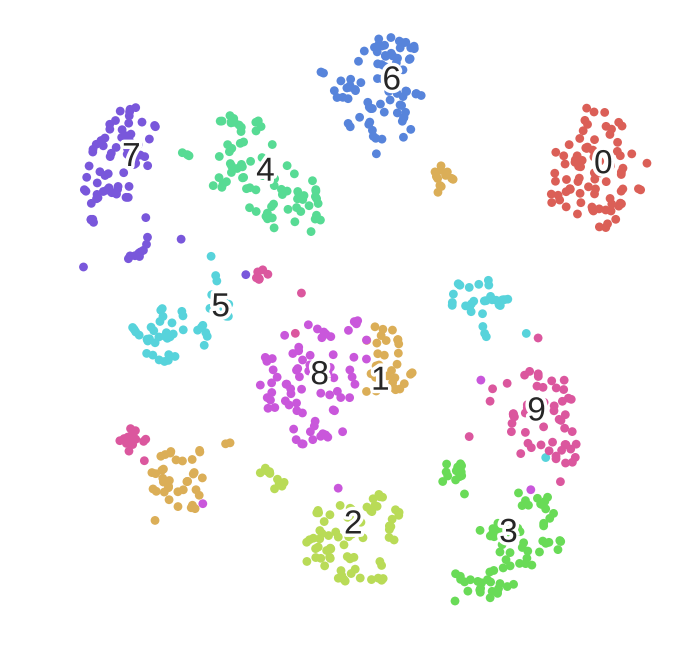

In [11]:
scatter(digits_proj, y)
plt.savefig('images/digits_tsne-generated.png', dpi=120)

In [12]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

In [13]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

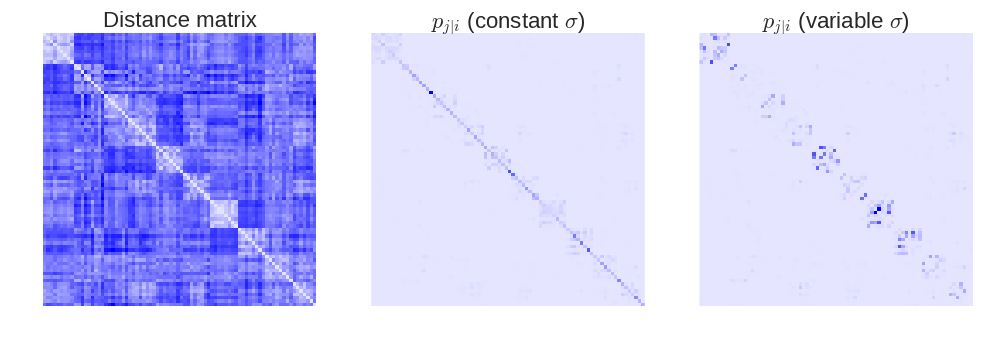

In [14]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
plt.savefig('images/similarity-generated.png', dpi=120)

## According to article at the URL:
### need to monkey around within built-in _gradient_descent
###   all we're doing is recording intermediate steps in array postion[]
### However, we get a signature error; probably b/c the below code is not consistent
### with current implementation in scikit-learn

In [15]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, n_iter_without_progress=30,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=[]):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [16]:
positions

[]

In [17]:
X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

ValueError: need at least one array to concatenate